# Synthetic Experiments

In [5]:
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import numpy as np
import pylab as plt
import tqdm
import math

from utils.xedl import xEDLWrapper
from copy import deepcopy
from sklearn.datasets import make_blobs, make_moons, make_circles, make_checkerboard, make_swiss_roll
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def plot_contour(net, X, y, width=4, res=.01):
    net.cpu()
    xx, yy = np.mgrid[-width:width:res, -width:width:res]
    zz = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    
    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.title('Aleatoric Uncertainty -- $u_a$')
    with torch.no_grad():
        aleatoric_unc = net.predict_aleatoric(zz)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=4, s=10)
    c = plt.contourf(xx, yy, aleatoric_unc.view(xx.shape), levels=np.linspace(0, 1, 6), zorder=3, alpha=.7)
    plt.colorbar(c)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Feature $x_1$')
    plt.ylabel('Feature $x_2$')

    plt.subplot(122)
    plt.title('Epistemic Uncertainty -- $u_e$')
    with torch.no_grad():
        epistemic_unc = net.predict_epistemic(zz)
    plt.scatter(X[:, 0], X[:, 1], c=y, zorder=4, s=10)
    c = plt.contourf(xx, yy, epistemic_unc.view(xx.shape), levels=np.linspace(0, 1, 6), zorder=3, alpha=.7)
    plt.colorbar(c)
    plt.xlabel('Feature $x_1$')
    plt.ylabel('Feature $x_2$')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

## Aleatoric Uncertainty

In [7]:
resolution = 100
n_epochs = 500

n_samples_train = 200
n_samples_test = 200
random_state = 1
var = 1

bw = .1
net_init = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), nn.Linear(50, 50), nn.ReLU(), nn.Linear(50, 2))
net_init.n_classes = 2

results_aleatoric = []
means = np.linspace(0, 2.5, resolution)

lmbds = [0.1, 0.3, .5, .7, .9]
for lmb in lmbds:
    mean_distance = []
    aleatoric_uncertainties = []
    for mean in means:
        torch.manual_seed(random_state)
        X = torch.cat((torch.Tensor(n_samples_train//2, 2).normal_(-mean, var), torch.Tensor(n_samples_train//2, 2).normal_(mean, var)))
        y = torch.cat((torch.zeros(n_samples_train//2), torch.ones(n_samples_train//2))).long()
        X = (X - X.mean(0)) / X.std(0)
        X_train, y_train = X, y

        X_test = torch.cat((torch.Tensor(n_samples_test//2, 2).normal_(-mean, var), torch.Tensor(n_samples_test//2, 2).normal_(mean, var)))
        y_test = torch.cat((torch.zeros(n_samples_test//2), torch.ones(n_samples_test//2))).long()
        X_test = (X_test - X_test.mean(0)) / X_test.std(0)

        kde = KernelDensity(bandwidth=bw).fit(X_train)
        def gen_ood(X_batch, y_batch=None, boundary=1e-5, *args, **kwargs):
            device = X_batch.device
            n_samples = len(X_batch)
            ood_samples = []
            while len(ood_samples) < n_samples:
                outer = np.random.multivariate_normal(np.zeros(2), np.eye(2)*3, size=1000)
                ood_samples.extend(outer[kde.score_samples(outer) < np.log(boundary)])

            return torch.from_numpy(np.stack(ood_samples)).float()[:n_samples].to(device)

        train_ds = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128)

        net = xEDLWrapper(net=deepcopy(net_init), lmb=lmb, ood_generator=gen_ood)
        net.fit(
            train_loader,
            val_loader_in=train_loader,
            val_loader_out=train_loader,
            n_epochs=n_epochs,
            weight_decay=1e-3,
            verbose=0,
            device=device,
        )
        net.cpu()
        # plot_contour(net, X_test, y_test)
        mean_distance.append(math.sqrt((mean - -mean)**2))
        aleatoric_uncertainties.append(net.predict_aleatoric(X_test).mean())
    results_aleatoric.append((mean_distance, aleatoric_uncertainties))

Training on cpu.


[Ep 000] Loss (In/Out) = 0.696/0.118 | Acc=0.485/0.485 | AUROC=0.500

Training on cpu.


[Ep 000] Loss (In/Out) = 0.696/0.118 | Acc=0.485/0.485 | AUROC=0.500

Training on cpu.


[Ep 000] Loss (In/Out) = 0.696/0.119 | Acc=0.485/0.485 | AUROC=0.500

Training on cpu.


[Ep 000] Loss (In/Out) = 0.696/0.117 | Acc=0.485/0.485 | AUROC=0.500

Training on cpu.


[Ep 000] Loss (In/Out) = 0.695/0.116 | Acc=0.500/0.485 | AUROC=0.500



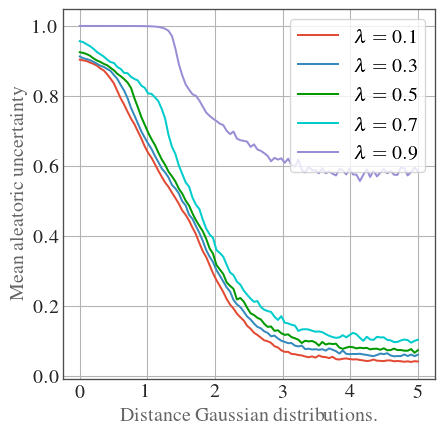

In [50]:
plt.figure(figsize=(5, 5))
for lmb, (mean_distance, aleatoric_uncertainties) in zip(lmbds, results_aleatoric):
    plt.plot(mean_distance, aleatoric_uncertainties, label=r'$\lambda = ' + '{:.1f}'.format(lmb) + '$')
    plt.xlabel('Distance Gaussian distributions.')
    plt.ylabel('Mean aleatoric uncertainty')
    plt.legend()
plt.show()

## Epistemic Uncertainty

In [10]:
n_epochs = 1000
mean = 2
random_state = 1
mean = 2
var = 1

n_samples_train = 500
n_samples_test = 500

n_draw = 2
steps = 20
n_samples_all = np.arange(2, 30, 2)

torch.manual_seed(random_state)
net_init = nn.Sequential(nn.Linear(2, 50), nn.ReLU(), nn.Linear(50, 50), nn.ReLU(), nn.Linear(50, 2))

torch.manual_seed(random_state)
X_test = torch.cat((torch.Tensor(n_samples_test//2, 2).normal_(-mean, var), torch.Tensor(n_samples_test//2, 2).normal_(mean, var)))
y_test = torch.cat((torch.zeros(n_samples_test//2), torch.ones(n_samples_test//2))).long()
X_test = (X_test - X_test.mean(0)) / X_test.std(0)

torch.manual_seed(random_state)
X = torch.cat((torch.Tensor(n_samples_train//2, 2).normal_(-mean, var), torch.Tensor(n_samples_train//2, 2).normal_(mean, var)))
y = torch.cat((torch.zeros(n_samples_train//2), torch.ones(n_samples_train//2))).long()
X = (X - X.mean(0)) / X.std(0)

results_epistemic = []

lmbds = [0.1, 0.3, .5, .7, .9]
for lmb in lmbds:
    epistemic_uncertainties = []
    n_samples_cur = []
    idx = list(range(len(X)))
    train_idx = []
    np.random.seed(0)

    for _ in range(steps):
        idx_add = np.c_[np.random.choice(idx[:n_samples_train//2], size=n_draw//2), np.random.choice(idx[n_samples_train//2:], size=n_draw//2)].flatten()
        for i in idx_add:
            idx.remove(i)
        train_idx.extend(idx_add)

        X_train, y_train = X[train_idx], y[train_idx]
        train_ds = torch.utils.data.TensorDataset(X_train, y_train)
        train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128)

        kde = KernelDensity(bandwidth=.1).fit(X_train)
        def gen_ood(X_batch, y_batch=None, boundary=1e-5, *args, **kwargs):
            device = X_batch.device
            n_samples = len(X_batch)
            ood_samples = []
            while len(ood_samples) < n_samples:
                outer = np.random.multivariate_normal(np.zeros(2), np.eye(2)*5, size=1000)
                ood_samples.extend(outer[kde.score_samples(outer) < np.log(boundary)])

            return torch.from_numpy(np.stack(ood_samples)).float()[:n_samples]
        
        net_init.n_classes = 2
        net = xEDLWrapper(net=deepcopy(net_init), lmb=lmb, ood_generator=gen_ood)
        net.fit(
            train_loader,
            val_loader_in=train_loader,
            val_loader_out=train_loader,
            n_epochs=n_epochs,
            weight_decay=1e-3,
            verbose=0,
            device=device,
        )

        # Create big and fixed size of test samples for representative evalaution of epistemicj
        # plot_contour(net, X_test, y_test, width=X_test.max().item(), res=.1)
        epistemic_uncertainties.append(net.predict_epistemic(X_test).mean())
        n_samples_cur.append(len(X_train))
    results_epistemic.append((n_samples_cur, epistemic_uncertainties))

Training on cpu.


[Ep 999] Loss (In/Out) = 0.010/0.000 | Acc=1.000/1.000 | AUROC=0.500

Training on cpu.


KeyboardInterrupt: 

In [12]:
plt.figure(figsize=(5, 5))
for lmb, (samples, epistemic_uncertainties) in zip(lmbds, results_epistemic):
    plt.plot(samples, epistemic_uncertainties, label=r'$\lambda = ' + '{:.1f}'.format(lmb) + '$')
    plt.xlabel('Number of Samples')
    plt.ylabel('Mean Epistemic Uncertainty')
    plt.legend()
plt.show()

<Figure size 480x480 with 0 Axes>

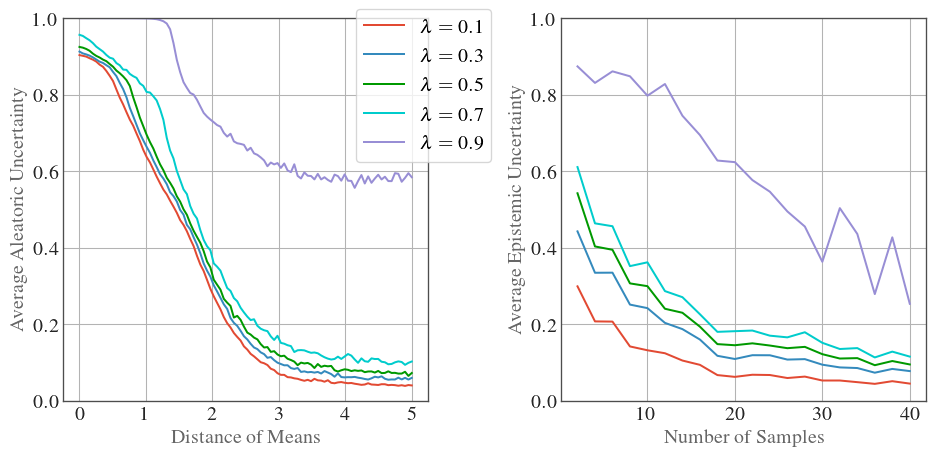

In [54]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)

for lmb, (mean_distance, aleatoric_uncertainties) in zip(lmbds, results_aleatoric):
    plt.plot(mean_distance, aleatoric_uncertainties, label=r'$\lambda = ' + '{:.1f}'.format(lmb) + '$')
    # plt.hlines(1, 0, 2, linestyle='--', linewidth=3, label='Maximum Aleatoric Uncertainty')
    # plt.xlim([0, 2])
    plt.ylim([0, 1])
    plt.xlabel('Distance of Means')
    plt.ylabel('Average Aleatoric Uncertainty')
          
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.subplot(122, sharey=ax)
          
for lmb, (samples, epistemic_uncertainties) in zip(lmbds, results_epistemic):
    # plt.hlines(1, 0, len(train_idx), linestyle='--', linewidth=3, label='Maximum Epistemic Uncertainty')
    plt.plot(samples, epistemic_uncertainties, label=r'$\lambda = ' + '{:.1f}'.format(lmb) + '$')
    plt.xlabel('Number of Samples')
    plt.ylabel('Average Epistemic Uncertainty')
    # plt.ylim((0, 1))
    
plt.tight_layout()
plt.savefig('./plots/synthetic.pdf')
plt.show()